<a href="https://colab.research.google.com/github/soulsharp/Attentive-Segnet/blob/main/Attentive_SegNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import cv2 as cv
import os
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter

In [ ]:
# files = os.listdir("/content/train")
# train_files = [file for file in files if file.endswith('jpg')]
# len(train_files)

117

In [ ]:
# files = os.listdir("/content/masks")
# masked_labels = [file for file in files if file.endswith("jpg")]
# len(masked_labels)

117

In [ ]:
# parent_path = "/content/train"
# train_data = []
# for file in train_files:
#   train_file = np.array(cv.imread(os.path.join(parent_path, file)))
#   train_data.append(train_file)


In [ ]:
# train_data[0].shape

(448, 448, 3)

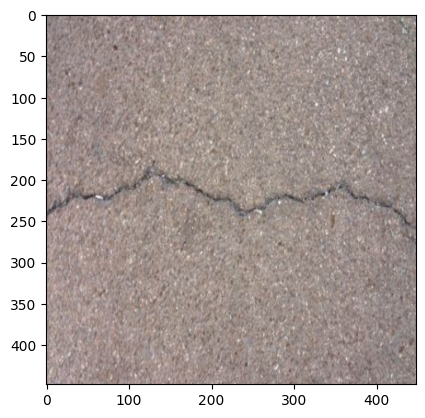

In [ ]:
# plt.imshow(train_data[0])

In [ ]:
# parent_path_2 = "/content/masks"
# masked_data = []
# for file in masked_labels:
#   masked_label = np.array(cv.imread(os.path.join(parent_path_2, file)))
#   masked_data.append(masked_label)

In [ ]:
# masked_data[0].shape

(448, 448, 3)

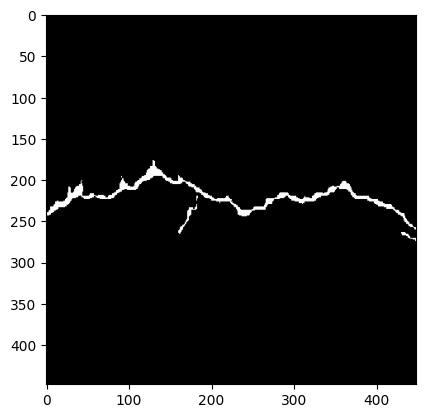

In [ ]:
# plt.imshow(masked_data[0])

In [ ]:
# # reshapes every element in the data arrays to channels, height, width
# def reshape_dims(data):
#   return [np.transpose(element, (2, 0, 1)) for element in data]

In [ ]:
# # since torch expects channels to be the first dimension
# train_data = reshape_dims(train_data)
# masked_data = reshape_dims(masked_data)

In [ ]:
# train_data[0].shape

(3, 448, 448)

In [ ]:
# Resizes the images from

In [ ]:
# masked_data[0]

array([[[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]]], dtype=uint8)

In [ ]:
# masked_data[0][masked_data[0] == 1].sum()

2589

In [ ]:
# def numpy_to_tensor(data):
#   return [torch.from_numpy(x).float() for x in data]

In [ ]:
# train_data = numpy_to_tensor(train_data)
# masked_data = numpy_to_tensor(masked_data)
# train_data[0].shape

torch.Size([3, 448, 448])

In [ ]:
def preprocess():
  pass

In [3]:
# Encodes patch representation of an image batch
class Patch_Embedding(nn.Module):
    def __init__(self, embed_dim=64, patch_size=32, in_channels=3):
        super(Patch_Embedding, self).__init__()
        self.patch_size = patch_size
        self.embed_dim = embed_dim
        self.convolution = nn.Conv2d(in_channels, embed_dim, kernel_size=patch_size, stride=patch_size)

    def forward(self, x):
        # Expects x to be of shape (batch_size, channels, height, width)
        h, w = x.shape[2], x.shape[3]
        if h % self.patch_size != 0 or w % self.patch_size != 0:
          raise ValueError("Input dimensions must be divisible by the patch size.")
        # Applies convolution to create patches
        patches = self.convolution(x)

        return patches

embedding_dim = 64
# patch information contains the patch embeddings of all training samples
patch_information = []
patch_embedding = Patch_Embedding(embed_dim=embedding_dim, patch_size=32, in_channels=3)

# Tensor for validating the entire process
test_tensor = torch.randn((2, 3, 512, 512))
output_patches = patch_embedding(test_tensor)
output_patch_encoding = output_patches.view(output_patches.size(0), -1, embedding_dim)

output_patch_encoding.shape

# for image in train_data:
#   output_patch = patch_embedding(image.unsqueeze(0))
#   # Intended shape of the encodings is : (Batch_size, num_patches, embed_dim)
#   output_patch_encoding = output_patch.view(output_patch.size(0),-1, embed_dim)
#   patch_information.append(output_patch_encoding)

# patch_information[0].shape

torch.Size([2, 256, 64])

In [4]:
# returns a tensor after applying maxpool2d
# also returns the indices used up in the max pool
class MaxPoolWithIndices(nn.Module):
    def __init__(self, kernel_size, stride):
        super(MaxPoolWithIndices, self).__init__()
        self.kernel_size = kernel_size
        self.stride = stride
        self.maxpool = nn.MaxPool2d(kernel_size=self.kernel_size, stride=self.stride, return_indices=True)

    def forward(self, x):
        output, indices = self.maxpool(x)
        return output, indices

In [5]:
max_pool = MaxPoolWithIndices(2, 2)
test_2 = torch.randn((2, 3, 512, 512))
reduced, reduced_indices = max_pool(test_2)

In [6]:
reduced.shape, reduced_indices[0, 1, 2, :]

(torch.Size([2, 3, 256, 256]),
 tensor([2560, 2051, 2053, 2054, 2056, 2058, 2572, 2063, 2064, 2579, 2580, 2582,
         2585, 2587, 2588, 2591, 2593, 2595, 2597, 2087, 2088, 2602, 2093, 2606,
         2096, 2098, 2613, 2102, 2105, 2618, 2109, 2110, 2112, 2627, 2629, 2630,
         2633, 2122, 2124, 2126, 2128, 2131, 2132, 2134, 2649, 2651, 2140, 2143,
         2144, 2659, 2660, 2151, 2152, 2666, 2157, 2159, 2673, 2163, 2676, 2678,
         2168, 2683, 2685, 2687, 2689, 2179, 2692, 2694, 2697, 2186, 2188, 2703,
         2704, 2707, 2197, 2199, 2201, 2202, 2205, 2718, 2208, 2210, 2213, 2215,
         2729, 2219, 2733, 2222, 2224, 2739, 2741, 2742, 2744, 2746, 2748, 2238,
         2240, 2754, 2244, 2759, 2760, 2763, 2765, 2766, 2256, 2259, 2260, 2775,
         2776, 2778, 2780, 2270, 2273, 2786, 2788, 2791, 2792, 2282, 2796, 2799,
         2288, 2803, 2805, 2806, 2296, 2810, 2813, 2814, 2817, 2306, 2821, 2310,
         2824, 2315, 2829, 2319, 2320, 2835, 2837, 2326, 2329, 2331, 2332, 284

In [7]:
# basic convblock with conv2d-->batchnorm-->relu-->maxpool(optional)
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride, padding, maxpool_flag=True):
        super(ConvBlock, self).__init__()
        self.maxpool_flag = maxpool_flag
        self.operation_seq = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, stride=stride, padding=padding),
            nn.BatchNorm2d(out_channels),
            nn.ReLU()
        )
        if self.maxpool_flag:
            self.maxpool = MaxPoolWithIndices(kernel_size=2, stride=2)

    def forward(self, x):
        x = self.operation_seq(x)
        print("Shape of x before maxpool is ", x.shape)
        if self.maxpool_flag:
            pooled, indices = self.maxpool(x)
            return pooled, indices
        else:
            return x, None

In [8]:
# Shape checks
conv_op_1 = ConvBlock(3, 8, 3, 1, 1)
x1, m1 = conv_op_1(test_2)
print("Block1", x1.shape, m1.shape)
conv_op_2 = ConvBlock(8, 16, 3, 1, 1)
x2, m2 = conv_op_2(x1)
print("Block2", x2.shape, m2.shape)
conv_op_3 = ConvBlock(16, 32, 3, 1, 1)
x3, m3 = conv_op_3(x2)
print("Block3", x3.shape, m3.shape)
conv_op_4 = ConvBlock(32, 64, 3, 4, 1, False)
x4, m4 = conv_op_4(x3)
print("Block4", x4.shape)

Shape of x before maxpool is  torch.Size([2, 8, 512, 512])
Block1 torch.Size([2, 8, 256, 256]) torch.Size([2, 8, 256, 256])
Shape of x before maxpool is  torch.Size([2, 16, 256, 256])
Block2 torch.Size([2, 16, 128, 128]) torch.Size([2, 16, 128, 128])
Shape of x before maxpool is  torch.Size([2, 32, 128, 128])
Block3 torch.Size([2, 32, 64, 64]) torch.Size([2, 32, 64, 64])
Shape of x before maxpool is  torch.Size([2, 64, 16, 16])
Block4 torch.Size([2, 64, 16, 16])


In [9]:
def Downsample(input_tensor):
    max_vals = {}
    max_indices = {}
    bottleneck_input = None

    assert input_tensor.shape[-2] % 4 == 0 and input_tensor.shape[-1] % 4 == 0, \
        "Input dimensions must be divisible by 4 for this downsampling pipeline."

    conv_blocks = [
        ("block1", ConvBlock(3, 8, 3, 1, 1)),
        ("block2", ConvBlock(8, 16, 3, 1, 1)),
        ("block3", ConvBlock(16, 32, 3, 1, 1)),
        ("block4", ConvBlock(32, 64, 3, 4, 1, False)),
    ]

    for name, conv_block in conv_blocks:
        input_tensor, indices = conv_block(input_tensor)

        # # Stores max values and indices with block name as key
        # max_vals[name] = input_tensor
        # max_indices[name] = indices

        if name == "block4":
            bottleneck_input = input_tensor

        else:
          max_vals[name] = input_tensor
          max_indices[name] = indices

    return max_vals, max_indices, bottleneck_input

In [10]:
# During training, input_image contains actual image info
input_image = torch.randn((2, 3, 512, 512))

max_vals, max_indices, bottleneck_input = Downsample(input_image)


Shape of x before maxpool is  torch.Size([2, 8, 512, 512])
Shape of x before maxpool is  torch.Size([2, 16, 256, 256])
Shape of x before maxpool is  torch.Size([2, 32, 128, 128])
Shape of x before maxpool is  torch.Size([2, 64, 16, 16])


In [13]:
# Shape checks
print(max_vals["block1"].shape, max_vals["block2"].shape,max_indices["block3"].shape)

torch.Size([2, 8, 256, 256]) torch.Size([2, 16, 128, 128]) torch.Size([2, 32, 64, 64])


In [15]:
len(max_indices)

3

In [16]:
max_indices["block2"].shape

torch.Size([2, 16, 128, 128])

In [17]:
# Attention weights to scale the patch embed representation
class AttentionWeights(nn.Module):
    def __init__(self, output_dim):
        super(AttentionWeights, self).__init__()
        self.alphas = nn.Parameter(torch.randn(output_dim))

    def forward(self, x):

        # adding a dimension ie making alphas (256, 1) for proper broadcasting
        scaled_input = self.alphas.unsqueeze(1) * x
        return scaled_input


In [18]:
# Shape test
att_wt = AttentionWeights(256)
test_data = torch.randn((2, 256, 64))
output = att_wt(test_data)

print("Shape of scaled input:", output.shape)

Shape of scaled input: torch.Size([2, 256, 64])


In [19]:
# Takes in the tensor containing patch information of all images in the batch
# Applies attention scaling on each image and returns BATCH_SZ X 256 X 64 tensor
def attention_to_all_images(patch_emb_tensor, attention_dim):
    att_weights = AttentionWeights(attention_dim)
    attended_inputs = att_weights(patch_emb_tensor)

    return attended_inputs

# Attention dimension is dependent on number of patches in each image
_, attention_dimension, _ = output_patch_encoding.shape
scaled_embeddings = attention_to_all_images(output_patch_encoding, attention_dimension)

print(scaled_embeddings.shape)

torch.Size([2, 256, 64])


In [20]:
print("Patch Embeddings", output_patch_encoding[0, 0, :])
print("Scaled Patch Embeddings", scaled_embeddings[0, 0, :])

Patch Embeddings tensor([-0.7303,  0.3829,  0.2100,  0.2285, -0.5159, -0.0293,  0.3307,  0.3034,
        -0.2431,  1.4052,  0.4912, -0.0190,  0.1289,  0.5000,  0.1855,  0.2674,
         0.8382, -0.1055, -1.0632,  1.5591,  0.3725, -0.6222,  0.5411, -0.1940,
         0.1234,  0.4549, -0.0585, -0.1008,  0.4207,  0.2406, -0.2583,  0.5685,
         0.4430, -0.0988, -0.6334, -0.5037, -1.0733,  0.2846,  0.0325, -0.2668,
        -0.2419, -0.0076, -0.6725, -0.0204,  0.5821, -0.1556, -0.6470,  0.2812,
         0.5999, -0.0402, -0.8675,  0.6554, -0.1853, -0.1283,  0.2879,  0.4530,
        -0.2863,  0.3059,  0.2927, -0.3255,  0.0335,  1.0276, -0.4796, -0.6326],
       grad_fn=<SliceBackward0>)
Scaled Patch Embeddings tensor([-1.0695,  0.5607,  0.3076,  0.3347, -0.7555, -0.0429,  0.4843,  0.4444,
        -0.3560,  2.0580,  0.7194, -0.0278,  0.1888,  0.7323,  0.2716,  0.3916,
         1.2275, -0.1545, -1.5570,  2.2833,  0.5455, -0.9112,  0.7925, -0.2841,
         0.1808,  0.6661, -0.0857, -0.1476,  

In [21]:
bottleneck_input.shape

torch.Size([2, 64, 16, 16])

In [22]:
# Takes in the bottleneck tensor and adds patch embeddings to it
def add_bottleneck_and_patch_embeddings(bottleneck, patch_embedding):

  num_batches, num_channels, h, w = bottleneck.shape
  patch_embedding = patch_embedding.permute(0, 2, 1)
  patch_embedding = patch_embedding.view(num_batches, num_channels, h, w)

  return bottleneck + patch_embedding

In [23]:
bottleneck_plus_emb = add_bottleneck_and_patch_embeddings(bottleneck_input, scaled_embeddings)

In [24]:
bottleneck_plus_emb.shape

torch.Size([2, 64, 16, 16])

In [25]:
class UpBlock(nn.Module):
    max_vals = None
    max_indices = None
    c = 0

    def __init__(self, in_channels, out_channels, kernel_size, stride, padding):
        super(UpBlock, self).__init__()
        self.operation_sequence = nn.Sequential(
            nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride, padding, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
        )

    def forward(self, x):
        output = self.operation_sequence(x)
        return output

In [26]:
class Unpool2d(nn.Module):
  def __init__(self, k_sz, stride):
    super(Unpool2d, self).__init__()
    self.unpool2d = nn.MaxUnpool2d(k_sz, stride)

  def forward(self, pooled, indices):
    return self.unpool2d(pooled, indices)

In [32]:
def Upsample(input_tensor):
    up_blocks = [
        UpBlock(64, 32, kernel_size=4, stride=4, padding=-0),
        Unpool2d(2, 2),
        UpBlock(32, 16, kernel_size=3, stride=1, padding=1),
        Unpool2d(2, 2),
        UpBlock(16, 8, kernel_size=3, stride=1, padding=1),
        Unpool2d(2, 2),
        UpBlock(8, 1, kernel_size=3, stride=1, padding=1),
    ]

    count = 0

    for idx, up_block in enumerate(up_blocks):
      if idx % 2 == 0:
        input_tensor = up_block(input_tensor)
      else:
        max_index_key = "block" + str(3-count)
        input_tensor = up_block(input_tensor, max_indices[max_index_key])
        count += 1
      print(f"Shape of input tensor after upsampling {idx + 1} times is {input_tensor.shape}")


Upsample(torch.randn((2, 64, 16, 16)))

Shape of input tensor after upsampling 1 times is torch.Size([2, 32, 64, 64])
Shape of input tensor after upsampling 2 times is torch.Size([2, 32, 128, 128])
Shape of input tensor after upsampling 3 times is torch.Size([2, 16, 128, 128])
Shape of input tensor after upsampling 4 times is torch.Size([2, 16, 256, 256])
Shape of input tensor after upsampling 5 times is torch.Size([2, 8, 256, 256])
Shape of input tensor after upsampling 6 times is torch.Size([2, 8, 512, 512])
Shape of input tensor after upsampling 7 times is torch.Size([2, 1, 512, 512])
